# Deep Learning Course Project

In this project, we will create a skin cancer (Melanoma) diagnoser that classifies chest images of skin if either it has melanoma or not

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="course-project")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kukuquack/course-project


'https://jovian.ai/kukuquack/course-project'

In [ ]:
project_name = 'course-project'

# Downloading the Dataset

In [ ]:
!pip install opendatasets --upgrade
import opendatasets as od
dataset_url = 'https://www.kaggle.com/drscarlat/melanoma'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarbinzayed
Your Kaggle Key: ··········


100%|██████████| 5.26G/5.26G [01:51<00:00, 50.5MB/s]


# Importing necessary libraries

In [ ]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
from torchvision import models
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
batch_size = 15
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
tsfm = tt.Compose([
    tt.Resize(224),
    tt.CenterCrop(224),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

Here we define the batch size and the transform that will be applied to the data.

## Defining the directory that contains the data

In [ ]:
train_dir = './melanoma/DermMel/train_sep'
val_dir = './melanoma/DermMel/valid'
test_dir = './melanoma/DermMel/test'

## Creating a dataloader of the dataset

In [ ]:
train_ds = ImageFolder(train_dir, transform=tsfm)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_ds = ImageFolder(val_dir, transform=tsfm)
val_dl = DataLoader(val_ds, batch_size * 2, shuffle=True, num_workers=2, pin_memory=True)
test_ds = ImageFolder(test_dir, transform=tsfm)
test_dl = DataLoader(test_ds, batch_size * 2, shuffle=True, num_workers=2, pin_memory=True)

Here we import the training set, validation set and the test set.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

Here, we define some helpful functions. The first denormalizes images so that we can see them in their normal form (as we have applied transformations). The show_batch function takes a DataLoader then displays one batch of the data.

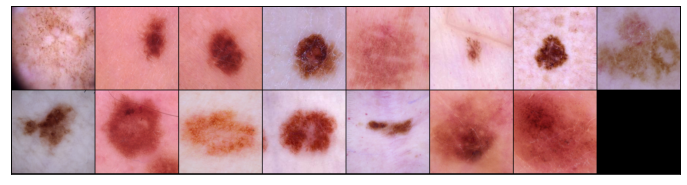

In [ ]:
show_batch(train_dl)

## Using a Graphics Card

Graphics cards provide quick computation and you will probably see them used in deep learning.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Setting the device that will do the computation

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

The ImageClassificationBase has useful functions that are helpful during training and validation and shows stats on them.

In [ ]:
class ResNetModel(ImageClassificationBase):
  def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet50()
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        
  def forward(self, xb):
        return self.network(xb)


model = to_device(ResNetModel(2), device)

Here we define the model that will classify images. We move the model to the gpu.

In [ ]:
model

ResNetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

Here we can see the structure of the model.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

Here, we are transferring the data to our GPU.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Defining functions for evaluation and fitting the model to the data

In [ ]:
evaluate(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'val_acc': 0.5006077885627747, 'val_loss': 1.4752020835876465}

Here we see how well the model performs before training, it is obvious that it will perform poorly, as the weights are random. The accuracy is about 50%, which is what we should get as this task is a binary classification task.

In [ ]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

These are the arguments that we will put in the fit_one_cycle as parameters

# Fitting the Model

In [ ]:
history = []

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
#epochs = 15, max_lr = 0.01, grad_clip = 0.1, weight_decay = 1e-4, opt_func = torch.optim.Adam

Epoch [0], last_lr: 0.00152, train_loss: 0.4883, val_loss: 1.9918, val_acc: 0.5535
Epoch [1], last_lr: 0.00436, train_loss: 0.4309, val_loss: 0.4675, val_acc: 0.7679
Epoch [2], last_lr: 0.00760, train_loss: 0.4025, val_loss: 0.3523, val_acc: 0.8605
Epoch [3], last_lr: 0.00971, train_loss: 0.2727, val_loss: 1.5426, val_acc: 0.5273
Epoch [4], last_lr: 0.00994, train_loss: 0.2049, val_loss: 0.1603, val_acc: 0.9391
Epoch [5], last_lr: 0.00950, train_loss: 0.2006, val_loss: 0.1988, val_acc: 0.9396
Epoch [6], last_lr: 0.00867, train_loss: 0.1865, val_loss: 0.4627, val_acc: 0.8173
Epoch [7], last_lr: 0.00750, train_loss: 0.1917, val_loss: 0.1766, val_acc: 0.9365
Epoch [8], last_lr: 0.00611, train_loss: 0.1782, val_loss: 0.1620, val_acc: 0.9378
Epoch [9], last_lr: 0.00463, train_loss: 0.1749, val_loss: 0.1749, val_acc: 0.9341
Epoch [10], last_lr: 0.00317, train_loss: 0.1741, val_loss: 0.1545, val_acc: 0.9398
Epoch [11], last_lr: 0.00188, train_loss: 0.1651, val_loss: 0.1666, val_acc: 0.9387
Ep

In [ ]:
train_time='34:29'

In [ ]:
evaluate(model, test_dl)

{'val_acc': 0.9337735176086426, 'val_loss': 0.1556542068719864}

Then we evaluate the model on the test dataset after training. We get pretty good results, over 93%.

# Plotting the Accuracy vs Epochs

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

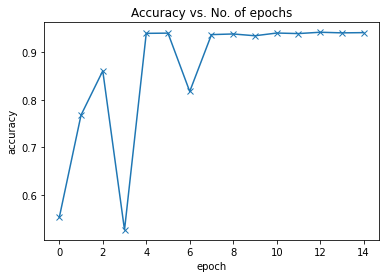

In [ ]:
plot_accuracies(history)

# Plottting the Loss vs Epochs

In [ ]:
 def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

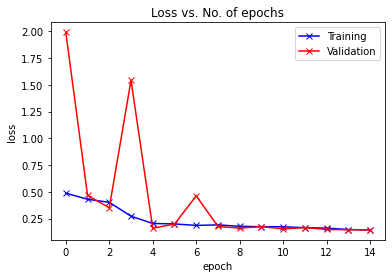

In [ ]:
plot_losses(history)

# Testing on single images

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Melanoma , Predicted: Melanoma


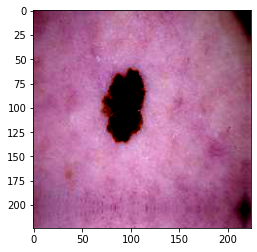

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
len(test_ds)

3561

Label: NotMelanoma , Predicted: NotMelanoma


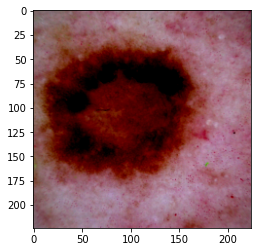

In [ ]:
img, label = test_ds[3560]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

# Saving the model's weights

After all the training and power that we have used, we should save our model so that we can use it later on, or perhaps we could continue training it to get better results.

In [ ]:
torch.save(model.state_dict(), 'skin-cancer-resnet50.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet50', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['skin-cancer-resnet50.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/kukuquack/course-project


'https://jovian.ai/kukuquack/course-project'

So... That's it! This was such a fun project while implementing it. I learned so much and I am looking forward to making much more in the future. I will upload soon the project in a blog post on my blog: https://kukuquack.github.io/home/ .